In [1]:
import torch
import pybullet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from locomotion.envs.gym_envs import A1GymEnv
from dynamics import *
import os

In [2]:
# Init the NN dynamics model
dynamics = Dynamics(
    n_in=31,
    n_hidden=500,
    n_out=19,
    depth=3,
)

# Create the robot environment
env = A1GymEnv(action_limit=(0.75, 0.75, 0.75), render=False, on_rack=False, lateralFriction=0.7)

device = "cpu"

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.X = np.load("./data/X.npy")
        self.y = np.load("./data/y.npy")
        self.len = self.X.shape[0]

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TrainDataset()
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

c:\Users\darsh\anaconda3\envs\mbrl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


100%|██████████| 1563/1563 [00:13<00:00, 111.89it/s]


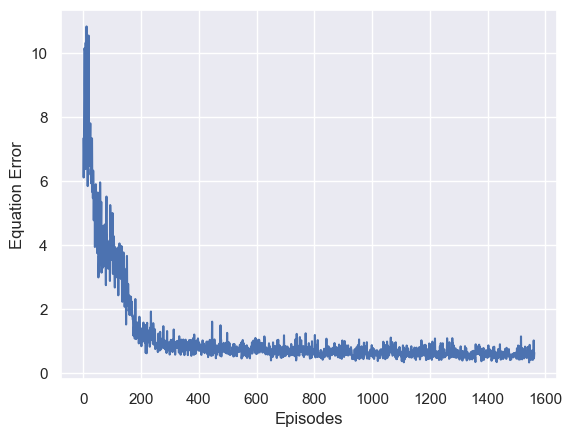

In [3]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr = 1e-4)
dynamics.train()
dynamics.to(device)
loss_function = torch.nn.MSELoss(reduction='mean')
losses = []

for X, y in tqdm(train_dataloader):
    X = X.to(dtype=torch.float32)
    y = y.to(dtype=torch.float32)
    pred_y = dynamics(X)
    loss = loss_function(y, pred_y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(dynamics.state_dict(), f"./logs/dynamics.pt")

plt.plot(losses)
plt.ylabel("Equation Error")
plt.xlabel("Episodes")
if not os.path.exists("./logs"):
    os.mkdir("./logs")
plt.savefig("./logs/delta_loss_1.png")